In [4]:
# Matplotlib
import matplotlib.pyplot as plt

# Numpy
import numpy as np
# Pillow
from PIL import Image
# Torch
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, models

# everywhere else
import pandas as pd
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import random 
import pickle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, multilabel_confusion_matrix

# custom code
from utils.datasets import *
from utils.config import *
from utils.network import *
from utils.netMixin import *
from utils.tester import *

# some misc modules
from os import listdir
from os.path import isfile, join

# init the torch seeds
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(100)
torch.cuda.manual_seed(100)
np.random.seed(100)
random.seed(100)

# Interfaces to interact with dataset

In [5]:
#----------------- instantiating all the datasets, and dataloaders ---------------#
datasets = {'full': lung_dataset(),'train': lung_train_dataset(), 'validation': lung_val_dataset(), 'test': lung_test_dataset()}
trainloader, validloader, testloader = load_data(datasets, hyperparams['dataloader']['params'])

In [6]:
@interact(name=datasets.keys())
def seeDescriptions(name):
    datasets[name].describe()

interactive(children=(Dropdown(description='name', options=('full', 'train', 'validation', 'test'), value='ful…

In [7]:
@interact(index=(0,1345), name=list(datasets.keys())[1:], cls=lung_dataset().classes.values())
def seeData(index, name, cls):
    try: datasets[name].show_img(cls, index)
    except: print("index out of range, max index for this dataset is {}".format(datasets[name].max))

interactive(children=(IntSlider(value=672, description='index', max=1345), Dropdown(description='name', option…

# Exploration of dataset 

#### Comparison of proportion of infected (covid and non-covid) vs normal lungs

In [8]:
# get the class names, and the number of data for each class
labels = datasets['train'].classes.values()
train_values = [v['number'] for v in datasets['train'].dataset.values()]
test_values = [v['number'] for v in datasets['test'].dataset.values()]

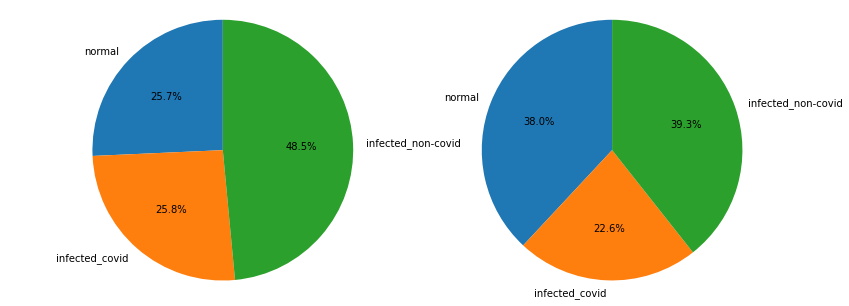

In [9]:
fig = plt.figure()

# plot the pie chart according to our data's proportion
ax1 = fig.add_axes([.1, .1, 1, 1], aspect=1)
patches, texts, autotexts = ax1.pie(train_values, labels=labels, autopct = '%1.1f%%', startangle=90)
ax1.axis('equal')

# plot the pie chart according to the population's proportion
ax2 = fig.add_axes([1, .1, 1, 1])
patches, texts, autotexts = ax2.pie(test_values, labels=labels, autopct = '%1.1f%%', startangle=90)
ax2.axis('equal')

plt.show()

From the pie charts above, we found out that there are  most cases of infected non-Covid x-rays for both the training and test dataset. For the training dataset, there is a noticeable data imbalance, with almost half (48.5%) of training samples being the infected non-Covid x-rays. 

This implies that the training data are not uniformly distributed among the classes.

#### Performance on existing models (resnet, alexnet, densenet)

In [10]:
#---------------- experimental results ------------------#
# retrieve names of results from experiments
results_filenames = [f for f in listdir(EXP_RESULTS_DIR) if isfile(join(EXP_RESULTS_DIR, f))] 

@interact(name=results_filenames, metric=['Training Loss',  'Validation Loss', 'Validation Accuracy'])
def seeLosses(name, metric):
  name = EXP_RESULTS_DIR + name
  with open(name, 'rb') as handle:
      all_results = pickle.load(handle)

  all_values = []
  for k,v in all_results.items():
    values = []
    for log in v:
      values.append(log[metric])
    all_values.append(values)

  # set the plot attributes before plotting the loss values
  fig = plt.figure()
  ax1 = fig.add_subplot()
  ax1.set_ylabel(metric)
  ax1.set_xlabel('Steps')
  fig.set_figheight(5)
  fig.set_figwidth(15)

  # plot the loss values
  for values in all_values:
      t = torch.tensor([range(len(values))]).reshape(-1)
      l = torch.tensor(values)
      plt.plot(t, values, '--o',label='line 1', linewidth=2)
      
  plt.legend(all_results.keys()) 
  # plt.ylim(0.2, 1.5) 
  plt.show() 

interactive(children=(Dropdown(description='name', options=('all_results.pkl', 'bin_01_2_all_results.pkl', 'bi…

Using the interface above, we can take a look at the training loss, validation loss, and validation accuracy when alexnet, resnet18 and densenet121 are trained with different separations of our dataset.

The results files are named by how the data has been separated.<br>
For example, bin_12_0_all_results.pkl are the results when<br>
- Data from class 1 (infected_covid) and 2 (infected_non-covid) are assigned as the negative class
- Data from class 0 (normal) is assigned as the positive class.

The analyses in the next 3 subsections are based on these experiment results.


#### 3-class-classifier vs stacked binary classifier


*The networks are not able to learn well when trained on the 3 classes.**
  - Results in *0_1_2_all_results.pkl* show that the training loss remains consistently high at around 1.0 for all the neural nets
  - Coresponding validation loss remains high as well
  - When the data is separated in a binary manner, the network seem to be able to learn useful features from the training set better. The can be seem in the general decline in the training losses for many of the results, as well as lower and declining validation losses.


#### Residual layers not performing well


The difference between alexnet, resnet18 and densenet121 are as follows:
  - Alexnet is the most basic CNN out of them all, only applying basic convolutions, pooling and normalization, without implementation of residual layers.
  - Resnet18 implement residual layers by connecting outputs from a block and the block before it.
  - Densenet121 implement residual layers in a more intense manner than Resnet18, where the residual layers are connected to every block that comes before it.

From our results, Alexnet achieves the most consistent performing network on our dataset. For all of the experiments, alexnet consistently achieves decreasing (or at least consistent) validation losses, while have a decreasing training loss. 

This shows that basic convolutional and pooling layers, would perform better than residual connections for our dataset.


# Preprocessing operations

In [11]:
preprocessing_params = hyperparams['preprocessing']

#### Gaussian blur
Gaussian blur is a standard preprocessing operation for computer vision models, it reduces the noise in the image.

<function matplotlib.pyplot.show>

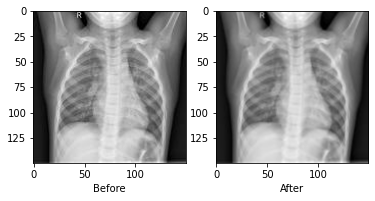

In [12]:
# use a sample image
original = datasets['train'].open_img('normal', 0)

# apply gaussian blur
kernel = preprocessing_params['gaussian_blur']['kernel']
tx = transforms.Compose([transforms.ToTensor(), transforms.GaussianBlur(kernel)])
after = tx(original)

# plot images
f, axarr = plt.subplots(1,2)
axarr[0].imshow(original, cmap='gray')
axarr[0].set_xlabel('Before')
axarr[1].imshow(transforms.ToPILImage()(after), interpolation="bicubic",  cmap='gray')
axarr[1].set_xlabel('After')
plt.show

#### Normalisation to set the values to be between -1 and 1

In [13]:
original = datasets['train'].open_img('normal', 0)
tx = transforms.Compose([transforms.ToTensor(),  transforms.Normalize([0.5], [0.5])])
after = tx(original)

print('---------------------Before normalization ---------------------')
print(original[0, 40:60])
print('\n---------------------After normalization ---------------------')
print(after.numpy()[0][0, 40:60])


---------------------Before normalization ---------------------
[0.17254902 0.20392157 0.09019608 0.03137255 0.00784314 0.
 0.00392157 0.02745098 0.03529412 0.28627451 0.43921569 0.45490196
 0.48627451 0.52941176 0.60784314 0.71372549 0.73333333 0.71764706
 0.73333333 0.78039216]

---------------------After normalization ---------------------
[-0.65490196 -0.59215686 -0.81960784 -0.9372549  -0.98431373 -1.
 -0.99215686 -0.94509804 -0.92941176 -0.42745098 -0.12156863 -0.09019608
 -0.02745098  0.05882353  0.21568627  0.42745098  0.46666667  0.43529412
  0.46666667  0.56078431]


By normalizing the data with a mean and standard deviation value of 0.5. The data are proportionally within the range of -1 an 1. This can be seen in the values before and after the normalization above.

# Data augmentation

#### Random Rotation

<function matplotlib.pyplot.show>

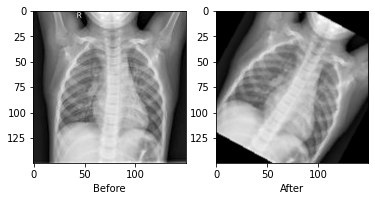

In [14]:
# use a sample image
original = datasets['train'].open_img('normal', 0)

# apply gaussian blur
degrees = preprocessing_params['affine']['degrees']
tx = transforms.Compose([transforms.ToTensor(), transforms.RandomAffine(degrees)])
after = tx(original)

# plot images
f, axarr = plt.subplots(1,2)
axarr[0].imshow(original, cmap='gray')
axarr[0].set_xlabel('Before')
axarr[1].imshow(transforms.ToPILImage()(after), interpolation="bicubic", cmap='gray')
axarr[1].set_xlabel('After')
plt.show

For our model to pick up on key features and leave out noise, we introduce random rotation of some of the images. However, this may make it more difficult for our model to learn the key features.

#### Random Vertical Flip

<function matplotlib.pyplot.show>

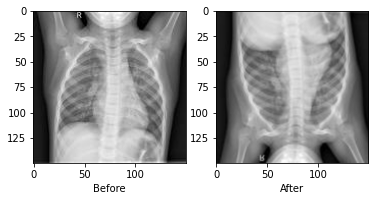

In [15]:
# use a sample image
original = datasets['train'].open_img('normal', 0)

# apply gaussian blur
tx = transforms.Compose([transforms.ToTensor(), transforms.RandomVerticalFlip()])
after = tx(original)

# plot images
f, axarr = plt.subplots(1,2)
axarr[0].imshow(original, cmap='gray')
axarr[0].set_xlabel('Before')
axarr[1].imshow(transforms.ToPILImage()(after), interpolation="bicubic", cmap='gray')
axarr[1].set_xlabel('After')
plt.show

Simliar to rotations, another form of augmentation that we introduce is flipping of some of the images.

# Model architecture
Based on our experiments, we have opted to build 2 neural networks, the first to separate the normal and the infected cases, and the second to separate the covid from the non-covid cases among the infected cases.

The model at its core is three stacked Conv-ReLU-MaxPool blocks with slightly different parameters.

For its training, we are using the following hyperparameters:
- Mini batch size of 32 samples
- 10 epochs
- Binary Cross Entropy (with logits) loss
- Adam optimizer with a learning rate of 0.001





In [16]:
#--------------load both models ------------#
model1 = LungDetectorModel(1)
model1.load_model(MODELS_DIR + FINAL_MODEL1_NAME + '.pt')

model2 = LungDetectorModel(1)
model2.load_model(MODELS_DIR + FINAL_MODEL2_NAME + '.pt')

# Predictions on Validation set

In [17]:
#-------------- prep the test data -----------------#
test_datasets = {'full': lung_dataset(),'train': lung_train_dataset(), 'validation': lung_val_dataset(), 'test': lung_test_dataset()}
_, validloader, testloader = load_data(test_datasets, hyperparams['dataloader']['params'])
# preprocessing
for dataset in test_datasets.values():
  dataset.set_tx(transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.5], [0.5])
                                  ]))

Evaluating on given set



Accuracy on validation set: 0.68


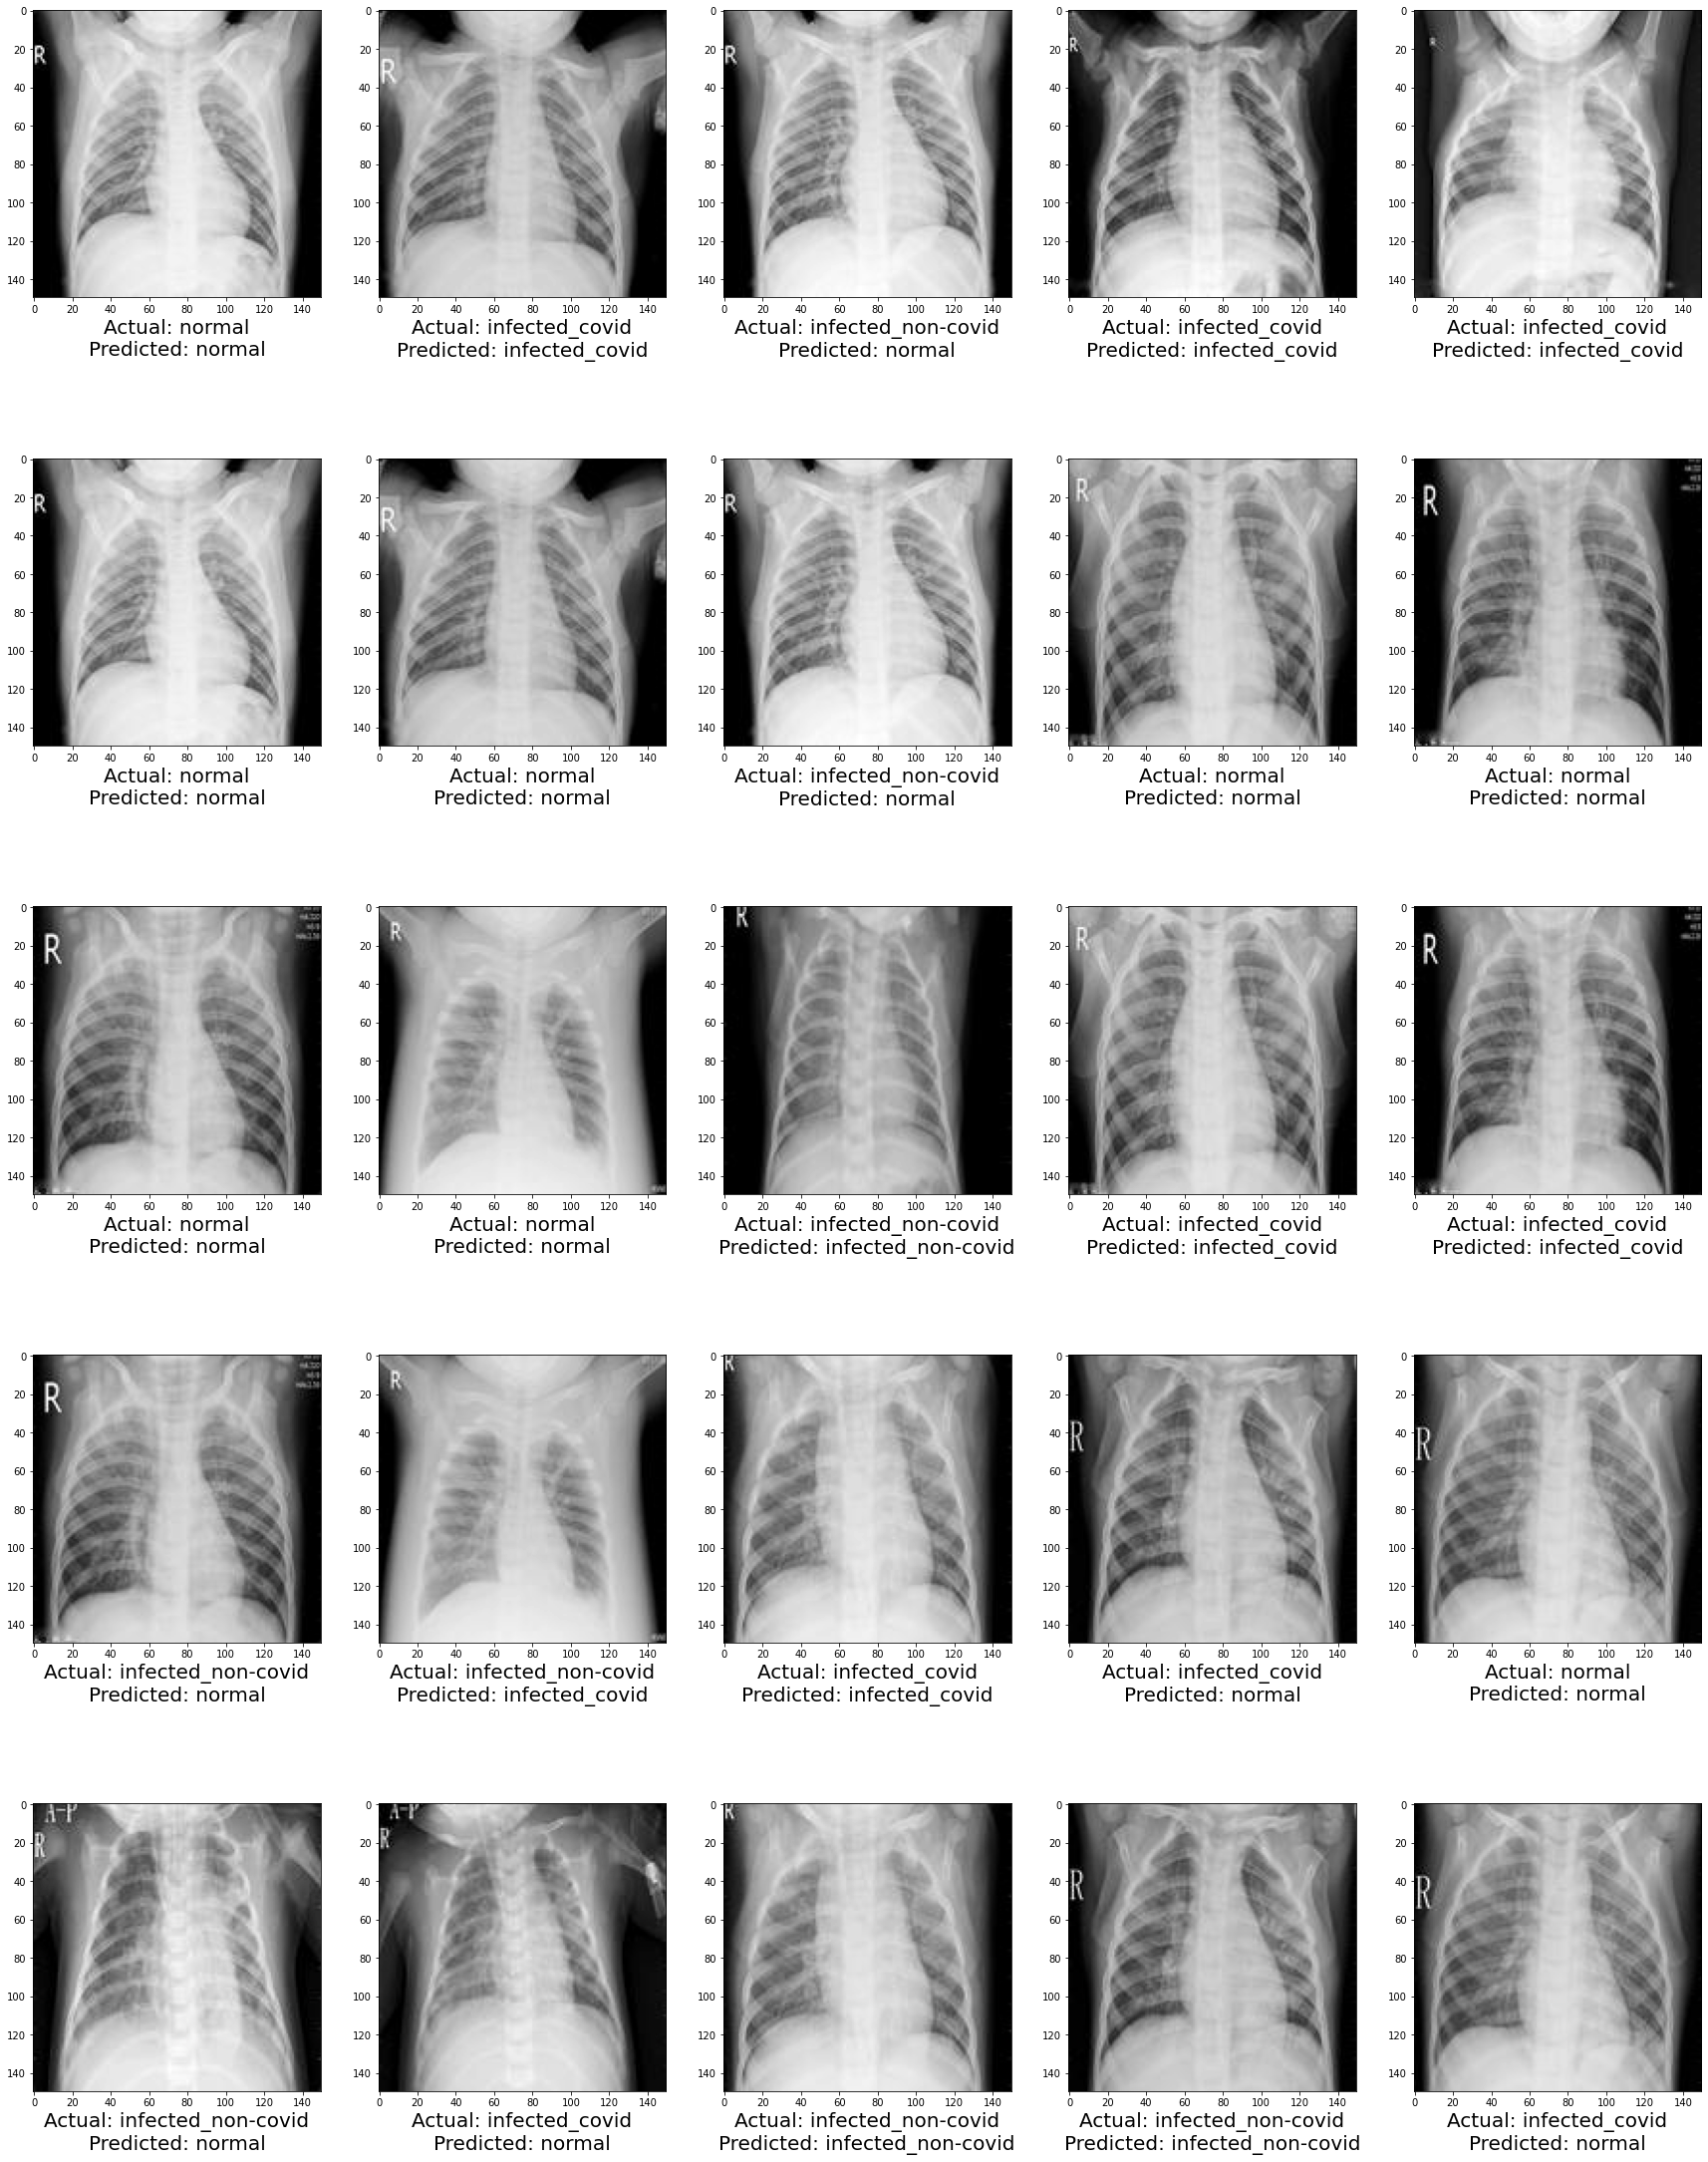

In [18]:
#------------ make predictions on validation set --------------#
# the positive class for model 1 is assigned to class 0 (normal)
# the positive class for model 2 is assigned to clas 2 (infected-non_covid)
THRESH1 = hyperparams['model']['thresh1']
THRESH2 = hyperparams['model']['thresh2']
predictions, truth = test_bin_class_model(model1, model2, 0, 2, validloader, model1_thresh=THRESH1, model2_thresh=THRESH2)
print(f'Accuracy on validation set: {(predictions == truth).sum().item() / len(truth)}')

cols, rows = 5, 5
f, axarr = plt.subplots(rows, cols)
f.set_figheight(40)
f.set_figwidth(30)
classes = test_datasets['validation'].classes
for img_idx in range(len(test_datasets['validation'])):
    i, j = img_idx//rows, img_idx%rows
    # get image
    cls_idx = [1 if img_idx < n else 0 for n in test_datasets['validation'].data_indexes].index(1)
    cls = test_datasets['validation'].classes[cls_idx]
    img = test_datasets['validation'].open_img(cls, j)

    # get truth and prediction
    true_label = classes[truth[img_idx]]
    predicted_label = classes[predictions[img_idx]]
    label = 'Actual: {}\nPredicted: {}'.format(true_label, predicted_label)
    axarr[i, j].imshow(img, cmap='gray')
    axarr[i, j].set_xlabel(label, fontsize = 20.0)

# Test Results

In [19]:
#------------ make predictions on test set --------------#
# the positive class for model 1 is assigned to class 0 (normal)
# the positive class for model 2 is assigned to clas 2 (infected-non_covid)
predictions, truth = test_bin_class_model(model1, model2, 0, 2, testloader, model1_thresh=THRESH1, model2_thresh=THRESH2)
print(f'Accuracy on test set: {(predictions == truth).sum().item() / len(truth)}')

Evaluating on given set



Accuracy on test set: 0.7902439024390244


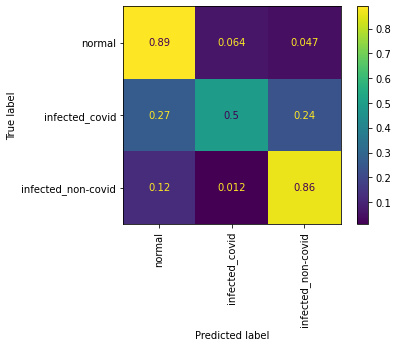

In [20]:
#------------- display 3 way confusion matrix ---------------#
cm = confusion_matrix(truth, predictions, normalize='true')
labels = list(test_datasets['test'].classes.values())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation='vertical')


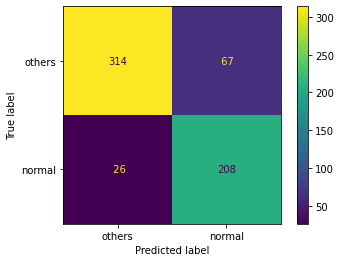

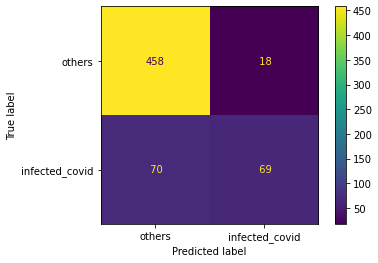

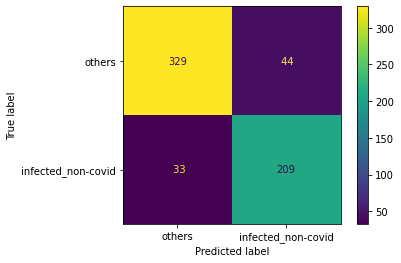

In [21]:
#--------------- display confusion matrix for individual class ------------------#
multilabel_cm = multilabel_confusion_matrix(truth, predictions)
for cls in list(test_datasets['test'].classes.values()):
  i = list(test_datasets['test'].classes.values()).index(cls)
  disp = ConfusionMatrixDisplay(confusion_matrix=multilabel_cm[i], display_labels=['others', cls])
  disp.plot(values_format='3d') 